Mounting Google Drive

In [10]:
from google.colab import drive

In [11]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Importing necessary Libraries

In [12]:
import os
from glob import glob
from PIL import Image, ImageOps
import random
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers

Defining *Image size*, *Batch size* and *Number of Images to be trained*

In [13]:
IMAGE_SIZE = 256
BATCH_SIZE = 64
NO_OF_TRAIN_IMAGES = 350

Getting different Images to *Train*, *validate* and *Test* the model

In [14]:
train_low_light_images = sorted(glob("/content/drive/MyDrive/Train/low/*"))[:NO_OF_TRAIN_IMAGES]
val_low_light_images = sorted(glob("/content/drive/MyDrive/Train/low/*"))[NO_OF_TRAIN_IMAGES:450]
test_low_light_images = sorted(glob("/content/drive/MyDrive/Train/low/*"))[450:]
test_high_light_images = sorted(glob("/content/drive/MyDrive/Train/high/*"))[450:]

Created functions to load the dataset of images

In [15]:
def dataset_gen(LL_images):
    dataset = tf.data.Dataset.from_tensor_slices((LL_images))
    dataset = dataset.map(load_image_data, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    return dataset

def load_image_data(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
    image = image / 255.0
    return image

Command to get the dataset to **Train** and **Validate** the model

In [16]:
train_dataset = dataset_gen(train_low_light_images)
val_dataset = dataset_gen(val_low_light_images)

print("Train Dataset:", train_dataset)
print("Validation Dataset:", val_dataset)

Train Dataset: <_BatchDataset element_spec=TensorSpec(shape=(64, 256, 256, 3), dtype=tf.float32, name=None)>
Validation Dataset: <_BatchDataset element_spec=TensorSpec(shape=(64, 256, 256, 3), dtype=tf.float32, name=None)>


To Construct a Deep Convolutional Enhancement Network(DCE Net) using Keras

In [18]:
def build_DCE_net():
    INPUT_IMAGE = keras.Input(shape=[None, None, 3])
    conv1 = layers.Conv2D(
        32, (3, 3), strides=(1, 1), activation="relu", padding="same"
    )(INPUT_IMAGE)
    conv2 = layers.Conv2D(
        32, (3, 3), strides=(1, 1), activation="relu", padding="same"
    )(conv1)
    conv3 = layers.Conv2D(
        32, (3, 3), strides=(1, 1), activation="relu", padding="same"
    )(conv2)
    conv4 = layers.Conv2D(
        32, (3, 3), strides=(1, 1), activation="relu", padding="same"
    )(conv3)
    int_con1 = layers.Concatenate(axis=-1)([conv4, conv3])
    conv5 = layers.Conv2D(
        32, (3, 3), strides=(1, 1), activation="relu", padding="same"
    )(int_con1)
    int_con2 = layers.Concatenate(axis=-1)([conv5, conv2])
    conv6 = layers.Conv2D(
        32, (3, 3), strides=(1, 1), activation="relu", padding="same"
    )(int_con2)
    int_con3 = layers.Concatenate(axis=-1)([conv6, conv1])
    x_r = layers.Conv2D(24, (3, 3), strides=(1, 1), activation="tanh", padding="same")(
        int_con3
    )
    return keras.Model(inputs=INPUT_IMAGE, outputs=x_r)

Added a function to find Exposure Loss

In [20]:
def exposure_loss(x, mean_val=0.6):
    x = tf.reduce_mean(x, axis=3, keepdims=True)
    get_mean_value = tf.nn.avg_pool2d(x, ksize=16, strides=16, padding="VALID")
    return tf.reduce_mean(tf.square(get_mean_value - mean_val))

Added a function to find Illumination Smoothness Loss

In [21]:
def illumination_smoothness_loss(x):
    batch_size = tf.shape(x)[0]
    h_x = tf.shape(x)[1]
    w_x = tf.shape(x)[2]
    h_count = (tf.shape(x)[2] - 1) * tf.shape(x)[3]
    w_count = tf.shape(x)[2] * (tf.shape(x)[3] - 1)
    h_tv = tf.reduce_sum(tf.square((x[:, 1:, :, :] - x[:, : h_x - 1, :, :])))
    w_tv = tf.reduce_sum(tf.square((x[:, :, 1:, :] - x[:, :, : w_x - 1, :])))
    batch_size = tf.cast(batch_size, dtype=tf.float32)
    h_count = tf.cast(h_count, dtype=tf.float32)
    w_count = tf.cast(w_count, dtype=tf.float32)
    return 2 * (h_tv / h_count + w_tv / w_count) / (batch_size)

Added a function to find Color Constancy Loss

In [19]:
def color_constancy_loss(x):
    mean_rgb_value = tf.reduce_mean(x, axis=(1, 2), keepdims=True)
    mr, mg, mb = mean_rgb_value[:, :, :, 0], mean_rgb_value[:, :, :, 1], mean_rgb_value[:, :, :, 2]
    drg = tf.square(mr - mg)
    drb = tf.square(mr - mb)
    dgb = tf.square(mg - mb)
    return tf.sqrt(tf.square(drg) + tf.square(drb) + tf.square(dgb))

Defined a class to find Spatial Consistency Loss

In [22]:
class spatial_consistency_loss(keras.losses.Loss):
    def __init__(self, **kwargs):
        super(spatial_consistency_loss, self).__init__(reduction="none")

        self.left_kernel = tf.constant(
            [[[[0, 0, 0]], [[-1, 1, 0]], [[0, 0, 0]]]], dtype=tf.float32
        )
        self.right_kernel = tf.constant(
            [[[[0, 0, 0]], [[0, 1, -1]], [[0, 0, 0]]]], dtype=tf.float32
        )
        self.up_kernel = tf.constant(
            [[[[0, -1, 0]], [[0, 1, 0]], [[0, 0, 0]]]], dtype=tf.float32
        )
        self.down_kernel = tf.constant(
            [[[[0, 0, 0]], [[0, 1, 0]], [[0, -1, 0]]]], dtype=tf.float32
        )

    def call(self, y_true, y_pred):

        mean_original = tf.reduce_mean(y_true, 3, keepdims=True)
        mean_enhanced = tf.reduce_mean(y_pred, 3, keepdims=True)

        pool_original = tf.nn.avg_pool2d(
            mean_original, ksize=4, strides=4, padding="VALID"
        )
        pool_enhanced = tf.nn.avg_pool2d(
            mean_enhanced, ksize=4, strides=4, padding="VALID"
        )

        d_left_original = tf.nn.conv2d(
            pool_original, self.left_kernel, strides=[1, 1, 1, 1], padding="SAME"
        )
        d_left_enhanced = tf.nn.conv2d(
            pool_enhanced, self.left_kernel, strides=[1, 1, 1, 1], padding="SAME"
        )

        d_right_original = tf.nn.conv2d(
            pool_original, self.right_kernel, strides=[1, 1, 1, 1], padding="SAME"
        )
        d_right_enhanced = tf.nn.conv2d(
            pool_enhanced, self.right_kernel, strides=[1, 1, 1, 1], padding="SAME"
        )

        d_up_original = tf.nn.conv2d(
            pool_original, self.up_kernel, strides=[1, 1, 1, 1], padding="SAME"
        )
        d_up_enhanced = tf.nn.conv2d(
            pool_enhanced, self.up_kernel, strides=[1, 1, 1, 1], padding="SAME"
        )

        d_down_original = tf.nn.conv2d(
            pool_original, self.down_kernel, strides=[1, 1, 1, 1], padding="SAME"
        )
        d_down_enhanced = tf.nn.conv2d(
            pool_enhanced, self.down_kernel, strides=[1, 1, 1, 1], padding="SAME"
        )

        d_left = tf.square(d_left_original - d_left_enhanced)
        d_right = tf.square(d_right_original - d_right_enhanced)
        d_up = tf.square(d_up_original - d_up_enhanced)
        d_down = tf.square(d_down_original - d_down_enhanced)
        return d_left + d_right + d_up + d_down

Defining a ZeroDCE class to implement a Keras model for the Zero-DCE (Zero-Reference Deep Curve Estimation) network\
\
Note that:\
While saving the weights, we simply save the weights of the DCE-Net\
While loading the weights, we simply load the weights of the DCE-Net

In [23]:
class ZeroDCE(keras.Model):
    def __init__(self, **kwargs):
        super(ZeroDCE, self).__init__(**kwargs)
        self.dce_model = build_DCE_net()

    def compile(self, learning_rate, **kwargs):
        super(ZeroDCE, self).compile(**kwargs)
        self.optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
        self.spatial_constancy_loss = spatial_consistency_loss(reduction="none")

    def get_enhanced_image(self, data, out):
        r1 = out[:, :, :, :3]
        r2 = out[:, :, :, 3:6]
        r3 = out[:, :, :, 6:9]
        r4 = out[:, :, :, 9:12]
        r5 = out[:, :, :, 12:15]
        r6 = out[:, :, :, 15:18]
        r7 = out[:, :, :, 18:21]
        r8 = out[:, :, :, 21:24]
        x = data + r1 * (tf.square(data) - data)
        x = x + r2 * (tf.square(x) - x)
        x = x + r3 * (tf.square(x) - x)
        enhanced_image = x + r4 * (tf.square(x) - x)
        x = enhanced_image + r5 * (tf.square(enhanced_image) - enhanced_image)
        x = x + r6 * (tf.square(x) - x)
        x = x + r7 * (tf.square(x) - x)
        enhanced_image = x + r8 * (tf.square(x) - x)
        return enhanced_image

    def call(self, data):
        dce_net_output = self.dce_model(data)
        return self.get_enhanced_image(data, dce_net_output)

    def compute_losses(self, data, output):

        enhanced_image = self.get_enhanced_image(data, output)

        loss_illumination = 200 * illumination_smoothness_loss(output)
        loss_exposure = 10 * tf.reduce_mean(exposure_loss(enhanced_image))
        loss_color_constancy = 5 * tf.reduce_mean(color_constancy_loss(enhanced_image))
        loss_spatial_constancy = tf.reduce_mean(self.spatial_constancy_loss(enhanced_image, data))

        total_loss = (
            loss_illumination
            + loss_exposure
            + loss_color_constancy
            + loss_spatial_constancy
        )
        return {
            "Total Loss": total_loss,
            "Illumination Smoothness Loss": loss_illumination,
            "Exposure Loss": loss_exposure,
            "Color Constancy Loss": loss_color_constancy,
            "Spatial Constancy Loss": loss_spatial_constancy,
        }

    def train_step(self, data):
        with tf.GradientTape() as tape:
            output = self.dce_model(data)
            losses = self.compute_losses(data, output)
        gradients = tape.gradient(
            losses["Total Loss"], self.dce_model.trainable_weights
        )
        self.optimizer.apply_gradients(zip(gradients, self.dce_model.trainable_weights))
        return losses

    def test_step(self, data):
        output = self.dce_model(data)
        return self.compute_losses(data, output)

    def save_weights(self, filepath, overwrite=True, save_format=None, options=None):
        self.dce_model.save_weights(
            filepath, overwrite=overwrite, save_format=save_format, options=options
        )

    def load_weights(self, path, name=False, skip_mismatch=False, options=None):
        self.dce_model.load_weights(
            by_name=name,
            filepath=path,
            options=options,
            skip_mismatch=skip_mismatch,
        )

Training our model for the given dataset

Epoch 1/100
5/5 [==============================] - 14s 1s/step - Total Loss: 5.4094 - Illumination Smoothness Loss: 2.4845 - Exposure Loss: 2.9224 - Color Constancy Loss: 0.0026 - Spatial Constancy Loss: 3.9418e-06 - val_Total Loss: 6.7719 - val_Illumination Smoothness Loss: 3.8394 - val_Exposure Loss: 2.9310 - val_Color Constancy Loss: 0.0015 - val_Spatial Constancy Loss: 4.1240e-06
Epoch 2/100
5/5 [==============================] - 6s 1s/step - Total Loss: 5.0199 - Illumination Smoothness Loss: 2.0982 - Exposure Loss: 2.9191 - Color Constancy Loss: 0.0026 - Spatial Constancy Loss: 6.4349e-06 - val_Total Loss: 6.2555 - val_Illumination Smoothness Loss: 3.3258 - val_Exposure Loss: 2.9282 - val_Color Constancy Loss: 0.0015 - val_Spatial Constancy Loss: 6.1013e-06
Epoch 3/100
5/5 [==============================] - 7s 1s/step - Total Loss: 4.7427 - Illumination Smoothness Loss: 1.8240 - Exposure Loss: 2.9160 - Color Constancy Loss: 0.0027 - Spatial Constancy Loss: 9.0910e-06 - val_Total L

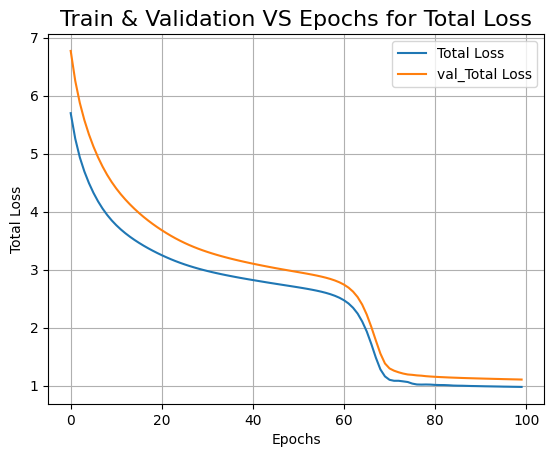

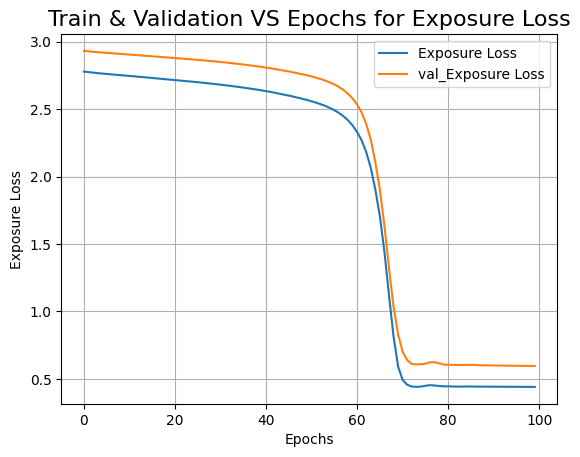

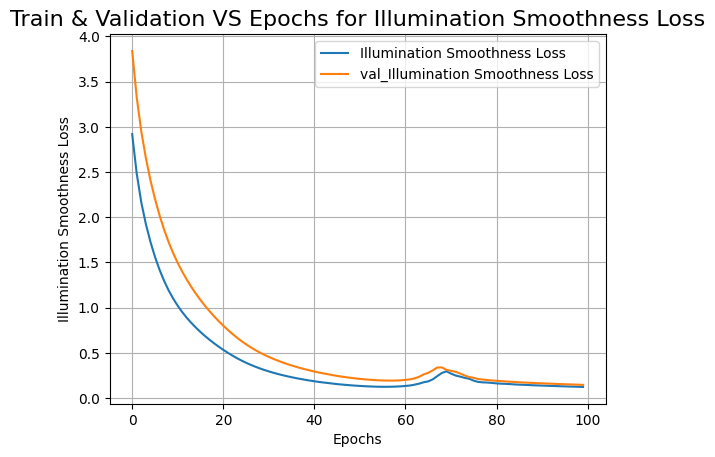

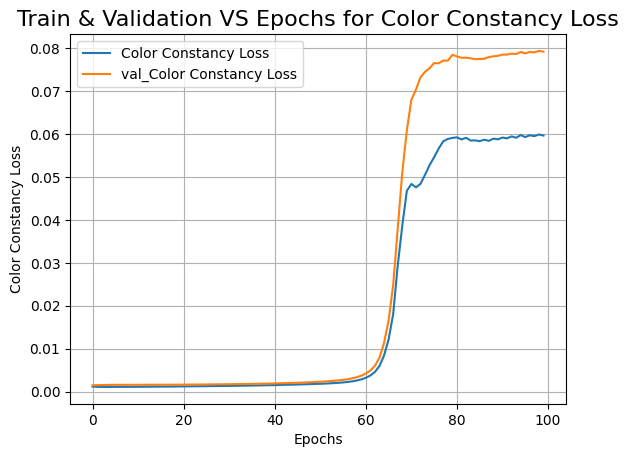

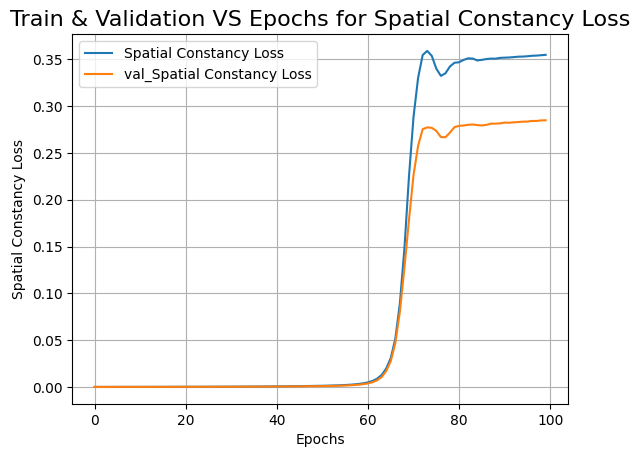

In [26]:
zero_dce_model = ZeroDCE()
zero_dce_model.compile(learning_rate=1e-4)
history = zero_dce_model.fit(train_dataset, validation_data=val_dataset, epochs=100)

def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train & Validation VS Epochs for {}".format(item), fontsize=16)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("Total Loss")
plot_result("Exposure Loss")
plot_result("Illumination Smoothness Loss")
plot_result("Color Constancy Loss")
plot_result("Spatial Constancy Loss")

In [34]:
def plot_results(images, titles, figure_size=(12, 12)):
    fig = plt.figure(figsize=figure_size)
    for i in range(len(images)):
        fig.add_subplot(1, len(images), i + 1).set_title(titles[i])
        _ = plt.imshow(images[i])
        plt.axis("off")
    plt.show()


def infer(original_image):
    input_image = keras.preprocessing.image.img_to_array(original_image)
    input_image = input_image.astype("float32") / 255.0
    input_image = np.expand_dims(input_image, axis=0)
    output_image = zero_dce_model(input_image)
    output_image = tf.cast((output_image[0, :, :, :] * 255), dtype=np.uint8)
    output_image = Image.fromarray(output_image.numpy())
    return output_image

In [38]:
def calculate_psnr(imageA,imageB):
  mse = calculate_mse(imageA,imageB)
  if mse==0:
    return float('inf')

  MAX_I = 255.0
  psnr = 20 * np.log10(MAX_I / np.sqrt(mse))
  return psnr


def calculate_mse(imageA,imageB):
  assert imageA.shape == imageB.shape,"The shape of both the images should be same"

  mse = np.mean((imageA - imageB)**2)
  return mse

In [36]:
def display_images(original_image, enhanced_image, original_hl_image, psnr_value):
  fig,axs = plt.subplots(1,3,figsize=(15,5))

  axs[0].imshow(original_image)
  axs[0].set_title("Low Light Image")
  axs[0].axis('off')

  axs[1].imshow(enhanced_image)
  axs[1].set_title(f"High Light Enhanced Image\nPSNR: {psnr_value:.2f} db")
  axs[1].axis('off')

  axs[2].imshow(original_hl_image)
  axs[2].set_title("Original High Light Image")
  axs[2].axis('off')

In [37]:
import cv2

#Array to store PSNR values of images
psnr_values = []

for val_image_file, high_light_file in zip(test_low_light_images,test_high_light_images):
    original_ll_image = Image.open(val_image_file)
    original_hl_image = Image.open(high_light_file)
    enhanced_image = infer(original_ll_image)

    # To Convert images into displayable format
    original_ll_image_np = np.array(original_ll_image)
    original_hl_image_np = np.array(original_hl_image)
    enhanced_image_np = np.array(enhanced_image)

    # To convert RGB images into GRAY scale to calculate PSNR value
    if original_ll_image_np.ndim == 3:
      original_ll_image_np = cv2.cvtColor(original_ll_image_np, cv2.COLOR_RGB2GRAY)
    if original_hl_image_np.ndim == 3:
      original_hl_image_np = cv2.cvtColor(original_hl_image_np, cv2.COLOR_RGB2GRAY)
    if enhanced_image_np.ndim == 3:
      enhanced_image_np = cv2.cvtColor(enhanced_image_np, cv2.COLOR_RGB2GRAY)

    # To plot the images
    # plot_results(
    #     [original_ll_image, enhanced_image, original_hl_image],
    #     ["Low Light Image","High Light Enhanced Image","Original High Light Image"],
    #     (20,12),
    # )

    # Calculating and storing PSNR value between High Light Original Image and Enhanced Image
    psnr_value = calculate_psnr(original_hl_image_np, enhanced_image_np)
    psnr_values.append(psnr_value)
    display_images(np.array(original_ll_image), np.array(enhanced_image), np.array(original_hl_image_np), psnr_value)
    # print(f'PSNR for {os.path.basename(val_image_file)}: {psnr_value}')

average_psnr = np.mean(psnr_values)
print(f'Average PSNR: {average_psnr}')

Output hidden; open in https://colab.research.google.com to view.